#Tarea: Análisis de Segmentación de Clientes con PCA y K-Means

# Nombre: Isaac Cueva

# Fecha: 09/06/2025

![Descripción de la imagen](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRP9d63jC144Usqa_NjecnoWcJXV60JuFTJLA&s)

Sesión de Spark

In [2]:
# Installing required packages
!pip install pyspark
!pip install findspark

In [3]:
# PySpark is the Spark API for Python. In this lab, we use PySpark to initialize the spark context.
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
# Provides findspark.init() to make pyspark importable as a regular library.
import findspark
findspark.init()

In [4]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("k-means") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
spark

#TAREAS

Aplicar técnicas de reducción de dimensionalidad (PCA) y clustering (K-Means) con Apache Spark para descubrir patrones de consumo y segmentos de clientes dentro del dataset de compras de Hunter’s e-grocery.

El dataset e información sobre el mismo, se encuentran en el siguiente enlace:

https://www.kaggle.com/datasets/hunter0007/ecommerce-dataset-for-predictive-marketing-2023/data



##Paso 1: Carga y preparación del dataset

1. Cargar el dataset en un dataframe de Spark.

In [7]:
# Cargar el archivo en un DataFrame de Spark
df = spark.read.csv("ECommerce_consumer behaviour.csv", header=True, inferSchema=True)
df.show(5)

+--------+-------+------------+---------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+------------------+
|order_id|user_id|order_number|order_dow|order_hour_of_day|days_since_prior_order|product_id|add_to_cart_order|reordered|department_id|department|      product_name|
+--------+-------+------------+---------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+------------------+
| 2425083|  49125|           1|        2|               18|                  NULL|        17|                1|        0|           13|    pantry|baking ingredients|
| 2425083|  49125|           1|        2|               18|                  NULL|        91|                2|        0|           16|dairy eggs|   soy lactosefree|
| 2425083|  49125|           1|        2|               18|                  NULL|        36|                3|        0|           16|dairy eggs|            butter|
| 24

2. Realizar un análisis exploratorio básico: conteo de filas, esquema, valores nulos, tipos de datos.

In [8]:
# Número total de filas
print("Número total de filas:", df.count())

Número total de filas: 2019501


In [9]:
# Esquema del DataFrame
df.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- product_name: string (nullable = true)



In [10]:
# Conteo de valores nulos por columna
from pyspark.sql.functions import col, count, isnan, when

null_counts = df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns
])
print("Valores nulos por columna:")
null_counts.show()

Valores nulos por columna:
+--------+-------+------------+---------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+------------+
|order_id|user_id|order_number|order_dow|order_hour_of_day|days_since_prior_order|product_id|add_to_cart_order|reordered|department_id|department|product_name|
+--------+-------+------------+---------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+------------+
|       0|      0|           0|        0|                0|                124342|         0|                0|        0|            0|         0|           0|
+--------+-------+------------+---------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+------------+



In [11]:
# Tipos de datos por columna
print("Tipos de datos:")
print(df.dtypes)

Tipos de datos:
[('order_id', 'int'), ('user_id', 'int'), ('order_number', 'int'), ('order_dow', 'int'), ('order_hour_of_day', 'int'), ('days_since_prior_order', 'double'), ('product_id', 'int'), ('add_to_cart_order', 'int'), ('reordered', 'int'), ('department_id', 'int'), ('department', 'string'), ('product_name', 'string')]


3. Seleccionar las columnas relevantes para el análisis:
user_id, order_number, order_dow, order_hour_of_day, days_since_prior_order, add_to_cart_order, reordered.

In [12]:
# Seleccionar columnas importantes
columnas_relevantes = [
    'user_id',
    'order_number',
    'order_dow',
    'order_hour_of_day',
    'days_since_prior_order',
    'add_to_cart_order',
    'reordered'
]

df_selected = df.select(columnas_relevantes)

print("Primeros registros de columnas seleccionadas:")
df_selected.show(5)


Primeros registros de columnas seleccionadas:
+-------+------------+---------+-----------------+----------------------+-----------------+---------+
|user_id|order_number|order_dow|order_hour_of_day|days_since_prior_order|add_to_cart_order|reordered|
+-------+------------+---------+-----------------+----------------------+-----------------+---------+
|  49125|           1|        2|               18|                  NULL|                1|        0|
|  49125|           1|        2|               18|                  NULL|                2|        0|
|  49125|           1|        2|               18|                  NULL|                3|        0|
|  49125|           1|        2|               18|                  NULL|                4|        0|
|  49125|           1|        2|               18|                  NULL|                5|        0|
+-------+------------+---------+-----------------+----------------------+-----------------+---------+
only showing top 5 rows



##Paso 2: Agregación de datos por usuario

4. Crear una tabla agregada que sintetice el comportamiento del cliente:

- Número total de órdenes (count(order_id))
- Promedio de productos por orden
- Porcentaje de productos reordenados
- Días promedio entre órdenes
- Hora promedio de compra

In [14]:
from pyspark.sql.functions import countDistinct, count, avg, sum, col

user_agg = df_selected.groupBy("user_id").agg(
    countDistinct("order_number").alias("total_orders"),
    (count("add_to_cart_order") / countDistinct("order_number")).alias("avg_products_per_order"),
    (sum("reordered").cast("double") / count("reordered")).alias("reorder_ratio"),
    avg("days_since_prior_order").alias("avg_days_between_orders"),
    avg("order_hour_of_day").alias("avg_order_hour")
)

print("Vista previa de la tabla agregada por usuario:")
user_agg.show(5)


Vista previa de la tabla agregada por usuario:
+-------+------------+----------------------+------------------+-----------------------+------------------+
|user_id|total_orders|avg_products_per_order|     reorder_ratio|avg_days_between_orders|    avg_order_hour|
+-------+------------+----------------------+------------------+-----------------------+------------------+
| 118185|          10|                   6.8|0.7647058823529411|      3.287878787878788|12.941176470588236|
|  68610|           4|                   5.5|0.6818181818181818|      5.045454545454546|12.636363636363637|
|   8086|           8|                  4.75|0.8157894736842105|     3.0526315789473686|14.052631578947368|
|  13623|           8|                   7.0|0.6071428571428571|     2.8035714285714284|11.232142857142858|
|  53191|           1|                   4.0|               0.5|                   10.0|              11.0|
+-------+------------+----------------------+------------------+-----------------------+-

##Paso 3: Vectorización y normalización

5. Usar VectorAssembler para combinar las columnas numéricas en un solo vector de características.

In [19]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Columnas de características
feature_cols = ["total_orders", "avg_products_per_order", "reorder_ratio", "avg_days_between_orders", "avg_order_hour"]

# Eliminar filas con nulls
user_agg_clean = user_agg.dropna(subset=feature_cols)

# VectorAssembler para combinar las características en una columna 'features'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(user_agg_clean)

6. Normalizar los datos con StandardScaler.

In [20]:
# Normalizar con StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Mostrar las primeras 5 filas con user_id y los features escalados
print("Vista previa de los datos escalados:")
scaled_data.select("user_id", "scaledFeatures").show(5, truncate=False)

Vista previa de los datos escalados:
+-------+------------------------------------------------------------------------------------------------------+
|user_id|scaledFeatures                                                                                        |
+-------+------------------------------------------------------------------------------------------------------+
|118185 |[5.66728930004598,-0.46908960044602965,0.671279566131419,-1.078646784381676,-0.15340765677904228]     |
|68610  |[1.4392144348399403,-0.6544185569135639,0.38409632649784387,-0.8865748536914222,-0.235838927021701]   |
|8086   |[4.257931011643967,-0.7613391087217568,0.8482702554132321,-1.104355141710907,0.14716583000605396]     |
|13623  |[4.257931011643967,-0.4405774532971782,0.12536672581413902,-1.13157300912545,-0.615585740592596]      |
|53191  |[-0.6748229977630802,-0.8682596605299496,-0.2458540056016113,-0.34513070424562076,-0.6783646935875532]|
+-------+--------------------------------------------------

##Paso 4: Aplicación de PCA

7. Reducir la dimensionalidad del dataset con PCA a 2 o 3 componentes principales.

In [21]:
from pyspark.ml.feature import PCA

# Definir el número de componentes a extraer
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")

# Entrenar el modelo PCA
pca_model = pca.fit(scaled_data)

# Aplicar la transformación PCA
pca_result = pca_model.transform(scaled_data)

# Mostrar la varianza explicada por cada componente
explained_variance = pca_model.explainedVariance.toArray()
print(f"Varianza explicada por componente: {explained_variance}")
print(f"Varianza total explicada (2 componentes): {explained_variance.sum()}")

# Mostrar un ejemplo de los datos con las componentes PCA
pca_result.select("user_id", "pcaFeatures").show(5, truncate=False)


Varianza explicada por componente: [0.29173288 0.20122383]
Varianza total explicada (2 componentes): 0.49295670576626427
+-------+-----------------------------------------+
|user_id|pcaFeatures                              |
+-------+-----------------------------------------+
|118185 |[-4.438956527364671,-0.08215210848748006]|
|68610  |[-1.6640175078383441,0.31883816830018596]|
|8086   |[-3.6935443928667087,0.44500765845706824]|
|13623  |[-3.389072379220869,-0.2907667728685839] |
|53191  |[0.1956581350938577,0.33387118511877406] |
+-------+-----------------------------------------+
only showing top 5 rows



In [26]:
pca_3 = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures3")
pca_model_3 = pca_3.fit(scaled_data)
pca_result_3 = pca_model_3.transform(scaled_data)

explained_variance_3 = pca_model_3.explainedVariance.toArray()
print(f"Varianza explicada por componente (3): {explained_variance_3}")
print(f"Varianza total explicada (3 componentes): {explained_variance_3.sum()}")

pca_result_3.select("user_id", "pcaFeatures3").show(5, truncate=False)


Varianza explicada por componente (3): [0.29173288 0.20122383 0.19852791]
Varianza total explicada (3 componentes): 0.6914846140614299
+-------+-------------------------------------------------------------+
|user_id|pcaFeatures3                                                 |
+-------+-------------------------------------------------------------+
|118185 |[-4.438956527364671,-0.08215210848748006,0.3902844851045946] |
|68610  |[-1.6640175078383441,0.31883816830018596,-0.3192146269768737]|
|8086   |[-3.6935443928667087,0.44500765845706824,0.26908282941933115]|
|13623  |[-3.389072379220869,-0.2907667728685839,-0.09762799798414755]|
|53191  |[0.1956581350938577,0.33387118511877406,-1.0847336936266134] |
+-------+-------------------------------------------------------------+
only showing top 5 rows



8. Explique si los dos componentes son significativos o no para explicar la variación de la data.

Los dos primeros componentes principales explican aproximadamente el 49.3% de la varianza total de los datos, lo que indica que capturan menos de la mitad de la variabilidad original. Esto sugiere que no son suficientes para representar de manera adecuada la información contenida en el dataset, ya que se pierde una parte significativa de la variabilidad. Por ello, incluir un tercer componente aumenta la varianza explicada a cerca del 69.1%, mejorando notablemente la capacidad de la reducción dimensional para preservar los patrones importantes en los datos.

##Paso 5: K-Means Clustering

9. Aplicar K-Means sobre las características reducidas (pcaFeatures).

In [27]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Usamos el dataframe con las 3 componentes PCA
pca_data_3 = pca_result_3.select("user_id", "pcaFeatures3")

10. Escoger el valor adecuado de K.

In [28]:
silhouette_scores = []

for k in range(2, 7):
    kmeans = KMeans(featuresCol='pcaFeatures3', k=k, seed=42)
    model = kmeans.fit(pca_data_3)
    predictions = model.transform(pca_data_3)

    evaluator = ClusteringEvaluator(featuresCol='pcaFeatures3', metricName='silhouette', distanceMeasure='squaredEuclidean')
    silhouette = evaluator.evaluate(predictions)

    print(f"Silhouette Score para k={k}: {silhouette}")
    silhouette_scores.append((k, silhouette))


Silhouette Score para k=2: 0.38200140984676595
Silhouette Score para k=3: 0.3995823408288355
Silhouette Score para k=4: 0.40615792662788325
Silhouette Score para k=5: 0.3984942478918629
Silhouette Score para k=6: 0.38404677794156306


Se evaluó el rendimiento del modelo K-Means utilizando la métrica de Silhouette Score para distintos valores de
k entre 2 y 6. El valor más alto (0.406) se obtuvo cuando
k=4, lo cual indica que este número de clústeres ofrece la mejor separación entre grupos en el espacio de las características reducidas. Por tanto, se selecciona
k=4 como el valor óptimo para entrenar el modelo final.


11. Entrene el modelo y calcule las etiquetas de los clusters.

In [29]:
# Entrenar el modelo con k=4
kmeans_opt = KMeans(featuresCol='pcaFeatures3', k=4, seed=42)
model_opt = kmeans_opt.fit(pca_data_3)

# Obtener las predicciones con etiquetas de cluster
predictions_opt = model_opt.transform(pca_data_3)
predictions_opt.select("user_id", "pcaFeatures3", "prediction").show(5, truncate=False)


+-------+-------------------------------------------------------------+----------+
|user_id|pcaFeatures3                                                 |prediction|
+-------+-------------------------------------------------------------+----------+
|118185 |[-4.438956527364671,-0.08215210848748006,0.3902844851045946] |3         |
|68610  |[-1.6640175078383441,0.31883816830018596,-0.3192146269768737]|3         |
|8086   |[-3.6935443928667087,0.44500765845706824,0.26908282941933115]|3         |
|13623  |[-3.389072379220869,-0.2907667728685839,-0.09762799798414755]|3         |
|53191  |[0.1956581350938577,0.33387118511877406,-1.0847336936266134] |2         |
+-------+-------------------------------------------------------------+----------+
only showing top 5 rows



12. Evalua el modelo con la métrica de Siluette Score. Interprete los resultados.

In [30]:
evaluator_opt = ClusteringEvaluator(featuresCol='pcaFeatures3', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette_opt = evaluator_opt.evaluate(predictions_opt)
print(f"Silhouette Score final con k=4: {silhouette_opt}")


Silhouette Score final con k=4: 0.40615792662788325


El modelo K-Means entrenado con k=4 fue evaluado mediante la métrica Silhouette Score, obteniendo un valor de aproximadamente 0.406. Este valor indica una buena cohesión intra-clúster y separación entre clústeres, lo que sugiere que el modelo agrupa a los usuarios de forma efectiva en función de las características extraídas mediante PCA.

13. Dibujar los clusters en un gráfico de dispersión sobre PCA1 vs PCA2.

In [34]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Definimos las funciones para extraer los componentes
get_pca1 = udf(lambda v: float(v[0]), FloatType())
get_pca2 = udf(lambda v: float(v[1]), FloatType())

# Agregamos las columnas al DataFrame
pca_with_clusters = predictions_opt \
    .withColumn("pca1", get_pca1("pcaFeatures3")) \
    .withColumn("pca2", get_pca2("pcaFeatures3"))


In [35]:
pandas_df = pca_with_clusters.select("pca1", "pca2", "prediction").toPandas()


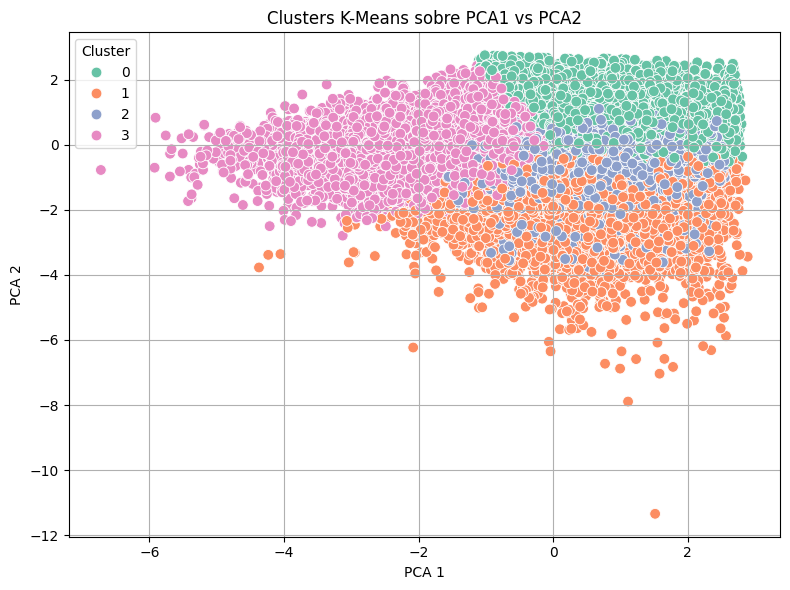

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pandas_df, x="pca1", y="pca2", hue="prediction", palette="Set2", s=60)
plt.title("Clusters K-Means sobre PCA1 vs PCA2")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


Según el gráfico de clústeres K-Means sobre PCA1 vs PCA2, podemos concluir que los clientes han sido exitosamente segmentados en cuatro grupos distintos, basándose en sus patrones de compra subyacentes capturados por las dos primeras componentes principales. La existencia de estas agrupaciones diferenciadas, respaldada por un Silhouette Score de 0.406, sugiere que existen perfiles de comportamiento de cliente únicos que pueden ser identificados y analizados para estrategias de marketing o servicio personalizadas, aunque se reconoce que esta visualización en 2D solo representa una parte de la variabilidad total de los datos.

##Paso 6: Análisis e interpretación de los clústeres

14. Mostrar el conteo de usuarios por clúster.

In [37]:
print("Conteo de usuarios por clúster:")
predictions_opt.groupBy("prediction").count().orderBy("prediction").show()

Conteo de usuarios por clúster:
+----------+-----+
|prediction|count|
+----------+-----+
|         0|27281|
|         1|14203|
|         2|26633|
|         3|30801|
+----------+-----+



15. Calcular estadísticas por clúster: promedio de carrito, tasa de reorden, etc.

In [38]:
clustered_users = predictions_opt.join(user_agg_clean, "user_id", "inner")

# Agrupar por la columna 'prediction' (el clúster asignado) y calcular el promedio de las características
print("\nEstadísticas promedio por clúster:")
cluster_summary = clustered_users.groupBy("prediction").agg(
    avg("total_orders").alias("avg_total_orders"),
    avg("avg_products_per_order").alias("avg_avg_products_per_order"),
    avg("reorder_ratio").alias("avg_reorder_ratio"),
    avg("avg_days_between_orders").alias("avg_avg_days_between_orders"),
    avg("avg_order_hour").alias("avg_avg_order_hour")
).orderBy("prediction")

cluster_summary.show()



Estadísticas promedio por clúster:
+----------+------------------+--------------------------+------------------+---------------------------+------------------+
|prediction|  avg_total_orders|avg_avg_products_per_order| avg_reorder_ratio|avg_avg_days_between_orders|avg_avg_order_hour|
+----------+------------------+--------------------------+------------------+---------------------------+------------------+
|         0|1.3487042263846634|          8.07837567049106|0.4510428248678212|         15.969258182818404|17.196253328265062|
|         1|1.6688023656973878|        22.741766992502747|0.5433093783090136|         14.362235950423306|13.194262933875414|
|         2|1.3488529268201104|         7.454595802200275|0.4890164720352301|          17.07366110094821|10.129509180694255|
|         3|3.1565533586571863|         8.317971340244158|0.7607752098669165|          6.727431327421788|13.308658473746496|
+----------+------------------+--------------------------+------------------+------------

16. Proponer perfiles para cada clúster (Ej: “Comprador frecuente”, “Comprador nocturno”, etc.)

###Clúster 0: "Los Compradores Ocasionales Nocturnos"

Características Clave: Este segmento realiza muy pocos pedidos (avg_total_orders bajo), con una frecuencia baja de compra (avg_avg_days_between_orders alto) y un ratio de reorden moderado. Su rasgo más distintivo es que prefieren comprar en las últimas horas de la tarde (avg_avg_order_hour más alta).

Perfil: Son clientes que compran de forma esporádica, sin una alta recurrencia de productos, y suelen hacerlo hacia el final del día. Podrían ser usuarios nuevos o aquellos que realizan compras por necesidad puntual.

###Clúster 1: "Los Compradores de Carrito Grande"

Características Clave: Aunque no son los más frecuentes en pedidos (avg_total_orders bajo), se destacan notablemente por el gran volumen de productos que adquieren en cada transacción (avg_avg_products_per_order significativamente alto). Su ratio de reorden es moderado y su frecuencia de compra es baja, con tendencia a comprar al mediodía.

Perfil: Clientes que hacen compras voluminosas, posiblemente para abastecerse. Son valiosos por el tamaño de sus carritos, lo que sugiere que podrían responder bien a promociones por cantidad o paquetes.

###Clúster 2: "Los Compradores Únicos Matutinos"

Características Clave: Presentan el promedio más bajo de pedidos (avg_total_orders muy bajo) y la mayor cantidad de días entre órdenes (avg_avg_days_between_orders muy alto), lo que indica una muy baja frecuencia. Su ratio de reorden también es bajo. Son distintivos por realizar sus compras predominantemente en las horas de la mañana (avg_avg_order_hour más baja).

Perfil: Este grupo representa a clientes muy poco frecuentes, que realizan compras de forma muy espaciada y con poca tendencia a reordenar. Suelen concentrar sus actividades de compra en la primera parte del día.

###Clúster 3: "Los Compradores Frecuentes y Leales"

Características Clave: Este es el segmento más activo y valioso, con el mayor número de pedidos (avg_total_orders más alto) y la más alta frecuencia de compra (avg_avg_days_between_orders más bajo). Además, demuestran una fuerte lealtad al negocio, evidenciada por el avg_reorder_ratio más alto. La cantidad de productos por pedido es moderada y suelen comprar al mediodía.

Perfil: Constituyen la base de clientes más fiel y recurrente. Son usuarios altamente comprometidos que realizan compras constantes y reordenan la mayoría de sus productos, siendo pilares importantes para el negocio.